In [3]:
import scanpy as sc 

adata = sc.read_h5ad('mela_haruka_res_new.h5ad')


In [6]:
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt


def create_circos_plot(df, 
                       cell_type_colors_hex=None,
                       cell_abundance=None, 
                       threshold=0.05,
                       edge_weights_scaler=42,
                       highlighted_edges=None,
                       node_weights_scaler=10000,
                       figure_size=(6,6),
                       save_path=None):

    # Function to apply an offset to the label positions
    def offset_label_position(pos, x_offset=0.15, y_offset=0.1):
        pos_offset = {}
        for node, coordinates in pos.items():
            theta = np.arctan2(coordinates[1], coordinates[0])
            radius = np.sqrt(coordinates[0] ** 2 + coordinates[1] ** 2)
            radius_offset = radius + radius * x_offset  # Increase the radius by x_offset%
            pos_offset[node] = (radius_offset * np.cos(theta), radius_offset * np.sin(theta))
        return pos_offset
        
    G = nx.Graph()
    for col in df.columns:
        cell_1, cell_2 = col
        if cell_type_colors_hex:
            G.add_node(cell_1, color=cell_type_colors_hex.get(cell_1))  # Set color if provided
            G.add_node(cell_2, color=cell_type_colors_hex.get(cell_2))  # Set color if provided
        else:
            G.add_node(cell_1)
            G.add_node(cell_2)
        weight = df[col].values[0]
        if weight >= threshold:
            G.add_edge(cell_1, cell_2, weight=weight*edge_weights_scaler)
              
    pos = nx.circular_layout(G, scale=1)
    
    ## Set node color by number of edges
    if not cell_type_colors_hex:
        degrees = dict(G.degree())
        max_degree = max(degrees.values())
        min_degree = min(degrees.values())
        cmap = plt.cm.coolwarm
        
        # Normalize the degrees to get a value between 0 and 1 to index the colormap
        norm = plt.Normalize(vmin=min_degree, vmax=max_degree)
        node_colors = [cmap(norm(degrees[node])) for node in G.nodes()]
    else:
        node_colors = [G.nodes[node]['color'] for node in G]
        
    # Scale node sizes from cell_abundance
    node_sizes = [cell_abundance[node].values[0] * node_weights_scaler for node in G.nodes()] 
    plt.figure(figsize=figure_size)
    ax = plt.gca()
    
    # Draw all nodes at once
    nx.draw_networkx_nodes(G, 
                           pos=pos,
                           node_size=node_sizes,
                           node_color=node_colors,
                           margins=[0.25,0.25])
    
    # Draw the node labels with the abundance values
    label_pos = offset_label_position(pos, x_offset=0.25)
    node_labels = {node: f'{node}\n{cell_abundance[node].values[0]*100:.2f}%' for node in G.nodes()}
    nx.draw_networkx_labels(G, 
                            pos=label_pos,
                            labels=node_labels,
                            font_family='Arial',
                            font_size=6)

    
    ## Customized Edge Drawing
    center_x, center_y = np.mean([pos[node] for node in G.nodes()], axis=0)
    highlight_color = 'g'  
    default_edge_color = 'k'  
    
    for edge in G.edges():
        node1, node2 = edge
        
        # Calculate the angle between the nodes and the center
        angle1 = np.arctan2(pos[node1][1] - center_y, pos[node1][0] - center_x)
        angle2 = np.arctan2(pos[node2][1] - center_y, pos[node2][0] - center_x)
    
        # Normalize the angles between -pi and pi
        angle1 = (angle1 + np.pi) % (2 * np.pi) - np.pi
        angle2 = (angle2 + np.pi) % (2 * np.pi) - np.pi
    
        # Calculate the angular distance and direction
        angular_dist = angle2 - angle1
        if angular_dist > np.pi:
            angular_dist -= 2 * np.pi
        elif angular_dist < -np.pi:
            angular_dist += 2 * np.pi
        
        # Set the curvature direction based on the angular distance
        rad = 0.2 * (np.pi - abs(angular_dist)) * (-1 if angular_dist > 0 else 1)
        
        # Check if the current edge should be highlighted
        if highlighted_edges and (edge in highlighted_edges or (edge[1], edge[0]) in highlighted_edges):
            edge_color = highlight_color
            transparency = 0.7
        else:
            edge_color = default_edge_color
            transparency = 0.3
            
        # Draw the edge with the customized curvature, direction, and color
        nx.draw_networkx_edges(G, 
                               pos=pos,
                               edgelist=[edge],
                               edge_color=edge_color,
                               width=[G[u][v]['weight'] for u, v in [edge]],
                               alpha=transparency,
                               arrows=True,
                               arrowstyle='-',
                               arrowsize=0,
                               connectionstyle=f'arc3,rad={rad}')

    ## Figure Settings
    plt.axis('off')
    plt.axis('equal')
    plt.tight_layout()
    
    ## Create a legend for edge widths
    edge_widths = [G[u][v]['weight'] for u, v in G.edges()]
    min_weight = np.min(edge_widths)  
    max_weight = np.max(edge_widths)
    num_values = 4 
    legend_values = np.linspace(min_weight, max_weight, num_values)
    
    for width in legend_values:
        plt.plot([0], [0], color='k', alpha=0.3, linewidth=width, 
                 label=f'{width/edge_weights_scaler:.2f}')
    plt.legend(loc='lower center', title = 'Edge width key: Co-Occurrence Frequency',bbox_to_anchor=(0.5, -0.05),ncol=len(legend_values))
    
    ## Create a colorbar for node color
    if not cell_type_colors_hex:
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, orientation='vertical', fraction=0.046, pad=0.04, label='Number of Edges of each Node')
    
    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)
        plt.show()
        plt.close()
    else:
        plt.show()

Processing region: 05_06_23_reg003.tsv at scale 32.0


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/mesa/ecospatial/_ecospatial.py:1281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  global_cell_count = spatial_df.groupby([library_key, cluster_key]).size().unstack(fill_value=0)


38.477 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 05_06_23_reg002.tsv at scale 32.0
38.379 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 05_06_23_reg001.tsv at scale 32.0
43.066 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 14_06_23_reg002.tsv at scale 32.0
54.590 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 14_06_23_reg001.tsv at scale 32.0
49.707 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 18_06_23_reg001.tsv at scale 32.0
62.305 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_06_26_reg003.tsv at scale 32.0
22.852 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_06_26_reg002.tsv at scale 32.0
34.277 per cent patches are empty
Using MoranI
Considering whole tissue


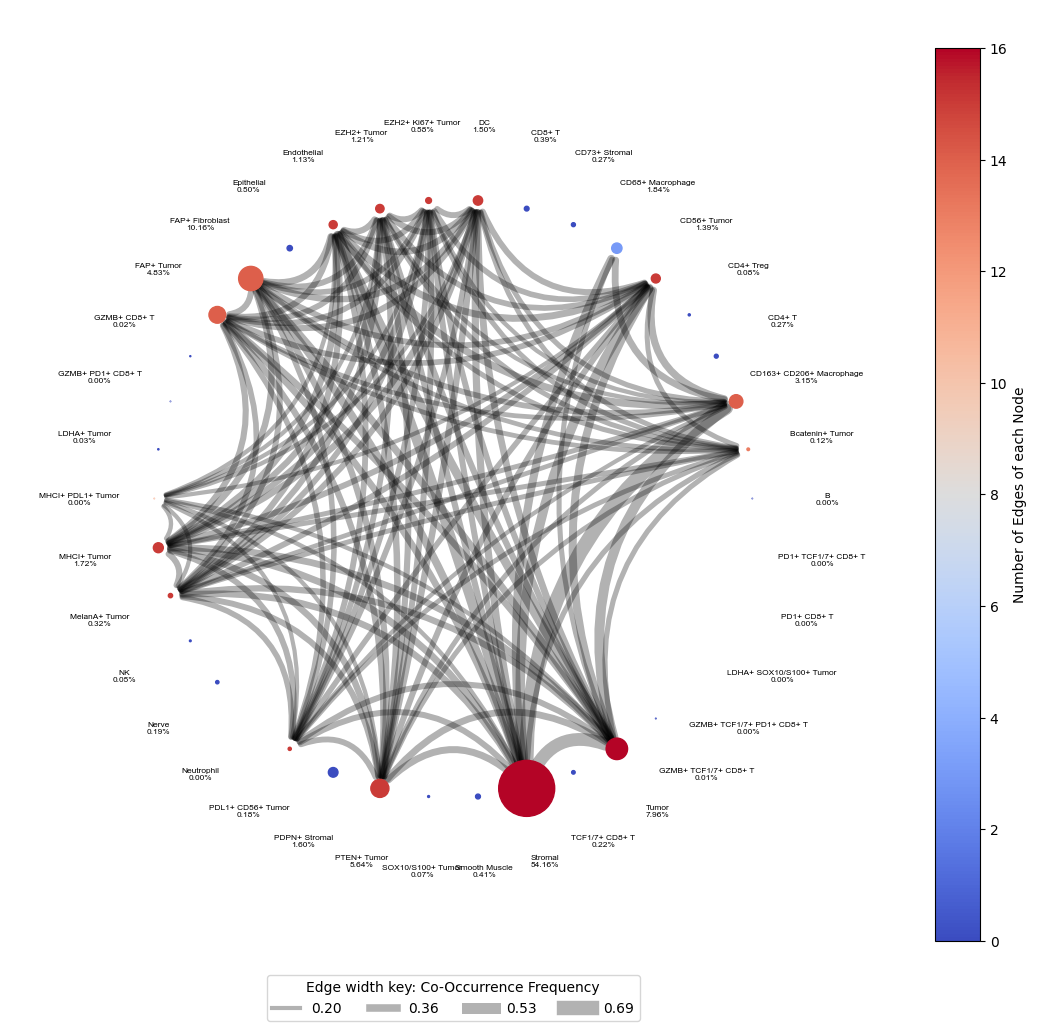

Processing region: 05_06_23_reg003.tsv at scale 32.0


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/mesa/ecospatial/_ecospatial.py:1281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  global_cell_count = spatial_df.groupby([library_key, cluster_key]).size().unstack(fill_value=0)


29.199 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 05_06_23_reg002.tsv at scale 32.0
33.984 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 05_06_23_reg001.tsv at scale 32.0
37.695 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 14_06_23_reg002.tsv at scale 32.0
39.160 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 14_06_23_reg001.tsv at scale 32.0
31.543 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 18_06_23_reg001.tsv at scale 32.0
26.562 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_06_26_reg003.tsv at scale 32.0
22.754 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_06_26_reg002.tsv at scale 32.0
37.012 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_07_01_reg002.tsv at scale 32.0


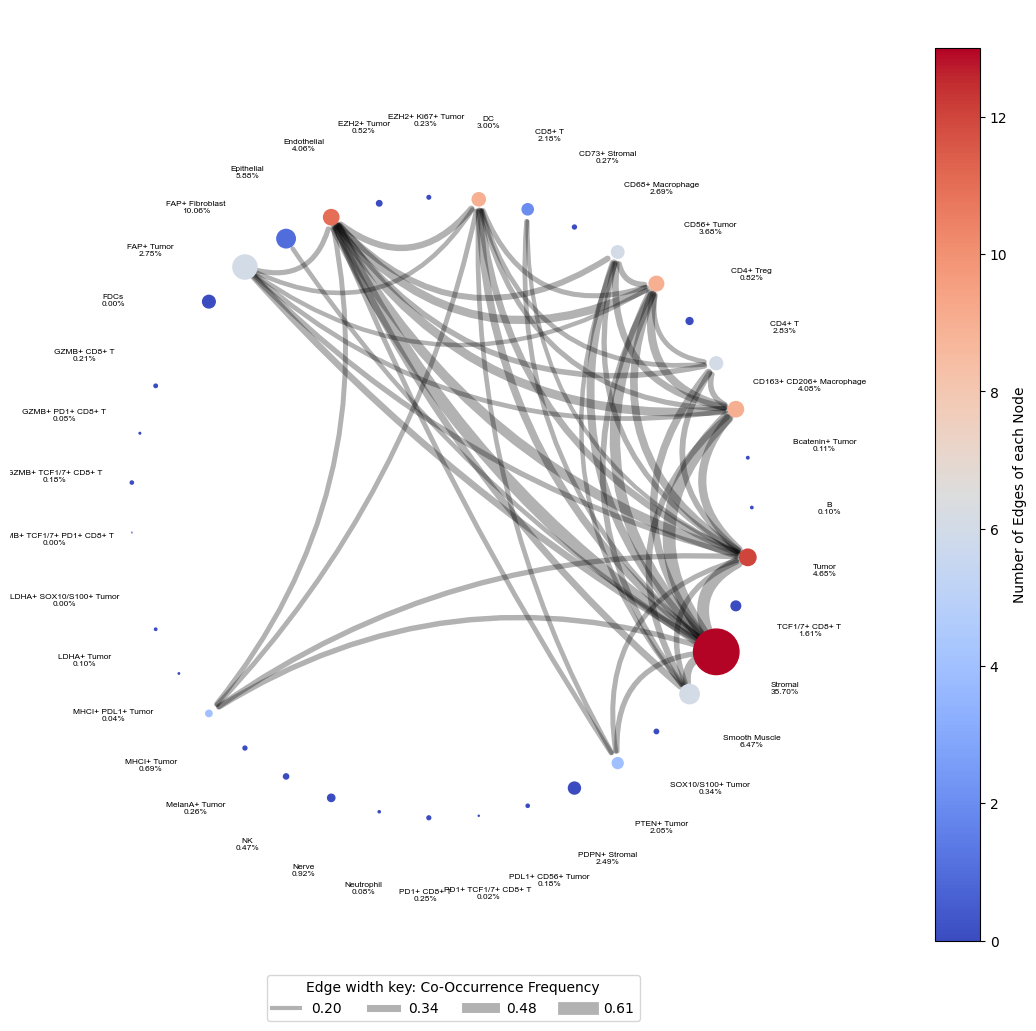

Processing region: 05_06_23_reg003.tsv at scale 32.0


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/mesa/ecospatial/_ecospatial.py:1281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  global_cell_count = spatial_df.groupby([library_key, cluster_key]).size().unstack(fill_value=0)


48.242 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 05_06_23_reg002.tsv at scale 32.0
47.363 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 05_06_23_reg001.tsv at scale 32.0
57.910 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 14_06_23_reg002.tsv at scale 32.0
41.699 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 14_06_23_reg001.tsv at scale 32.0
32.715 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 18_06_23_reg001.tsv at scale 32.0
31.543 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_06_26_reg003.tsv at scale 32.0
42.578 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_06_26_reg002.tsv at scale 32.0
54.980 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_07_01_reg002.tsv at scale 32.0


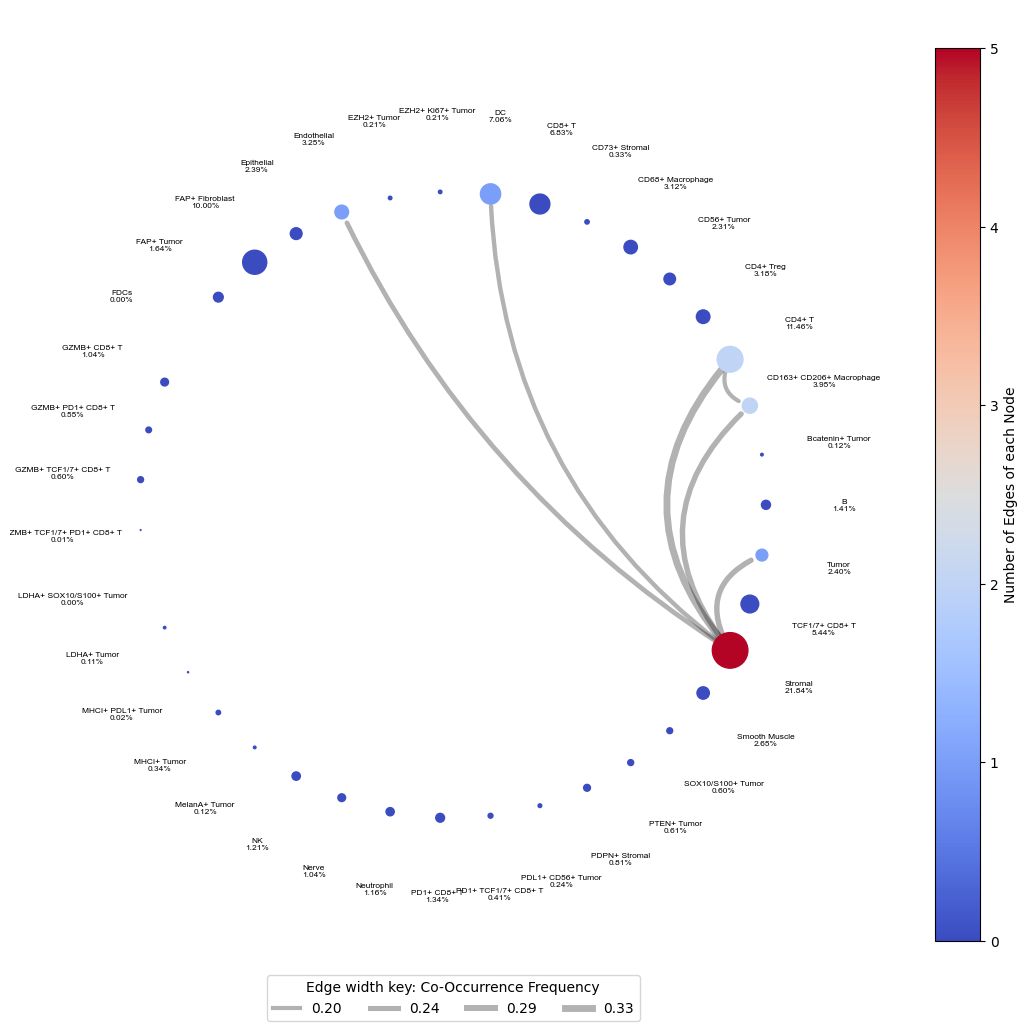

Processing region: 05_06_23_reg003.tsv at scale 32.0


/home/nasun/solexa_sun/lab_members/nasun/tools/miniconda3/envs/haru_repo_envi/lib/python3.11/site-packages/mesa/ecospatial/_ecospatial.py:1281: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  global_cell_count = spatial_df.groupby([library_key, cluster_key]).size().unstack(fill_value=0)


80.371 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 05_06_23_reg002.tsv at scale 32.0
83.691 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 05_06_23_reg001.tsv at scale 32.0
81.836 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 14_06_23_reg002.tsv at scale 32.0
69.141 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 14_06_23_reg001.tsv at scale 32.0
64.453 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 18_06_23_reg001.tsv at scale 32.0
72.754 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_06_26_reg003.tsv at scale 32.0
54.395 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_06_26_reg002.tsv at scale 32.0
50.684 per cent patches are empty
Using MoranI
Considering whole tissue
Processing region: 23_07_01_reg002.tsv at scale 32.0


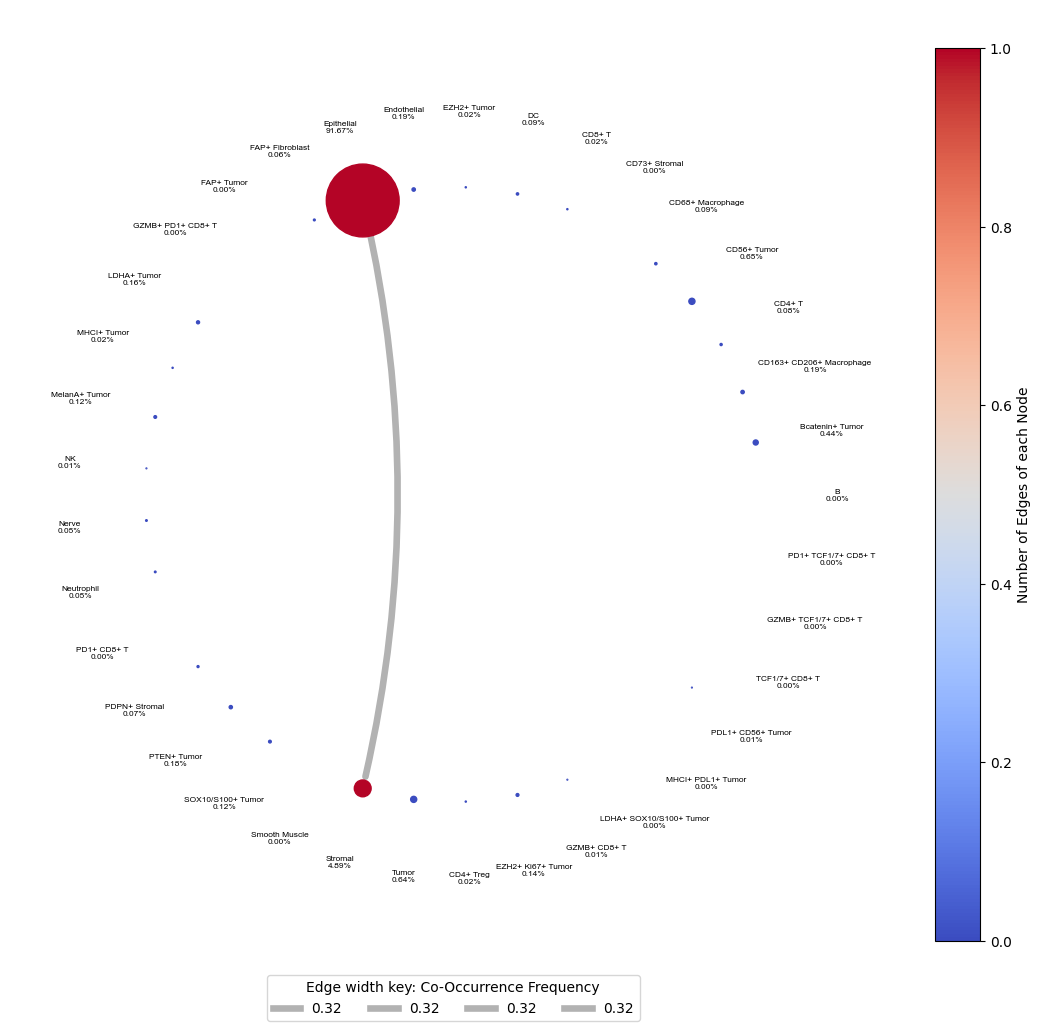

In [7]:
from mesa import ecospatial as eco
import pandas as pd 
# Extract relevant columns from adata.obs

for s in adata.obs['cluster_haruka_salient'].unique():
    

    cols_to_keep = ['Cell_Type', 'slice_id',  'cluster_haruka_salient']
    adata_new = adata[adata.obs['cluster_haruka_salient'] == s].copy()
    
    # Create dataframe with obs info and spatial coordinates
    liver_df = pd.DataFrame(adata_new.obs[cols_to_keep])
    liver_df['x'] = adata_new.obsm['spatial'][:,0] 
    liver_df['y'] = adata_new.obsm['spatial'][:,1]

    # Rename columns to match expected format


    # Get unique library IDs
    library_ids = liver_df['slice_id'].unique().tolist()


    global_cellfreq_df, global_co_occurrence_df = eco.spot_cellfreq(spatial_data=liver_df,
                                                                    scale=32.0,
                                                                    library_key='slice_id',
                                                                    library_id=library_ids ,
                                                                    spatial_key=['x', 'y'],
                                                                    cluster_key='Cell_Type',
                                                                    spots='global',
                                                                    top=None,
                                                                    selected_comb=None,
                                                                    restricted=False,
                                                                    metric='Shannon Diversity')

    circoplot_df1 = global_co_occurrence_df.sort_index(axis=1, level=[0,1])
    circoplot_df1 = circoplot_df1[[col for col in circoplot_df1.columns if 'undefined' not in col]]

    circoplot_df2 = global_cellfreq_df

    create_circos_plot(circoplot_df1,
                        cell_type_colors_hex=None,
                        cell_abundance=circoplot_df2,
                        threshold=0.2,
                        edge_weights_scaler=15,
                        highlighted_edges=None,
                        node_weights_scaler=3000,
                        figure_size=(10,10),
                        )